In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Cargamos Librerías y paquetes

In [2]:
print('Se están importando las librerías y paquetes necesarios...')
import os
import pandas as pd
import json
import pickle
import zipfile
import shutil
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

# Instalamos los paquetes necesarios para que funcione desde la Colab
!pip install avro-python3
!pip install tf_slim==1.1.0
!pip install tf-models-official==2.8.0
!pip install lvis
!pip install tensorflow_io==0.23.1
!pip install keras==2.8.0
!pip install opencv-python-headless==4.5.2.52


#Importamos los modelos necesarios
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git
%cd /content/models/
#!git checkout 58d19c67e1d30d905dd5c6e5092348658fed80af
!apt-get update && apt-get install -y -qq protobuf-compiler python-pil python-lxml python-tk
!pip install -q Cython contextlib2 pillow lxml matplotlib
!pip install -q pycocotools
%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'
!python object_detection/builders/model_builder_test.py

from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
import tensorflow as tf


print('Librerías y paquetes instalados conrrectamente')

Se están importando las librerías y paquetes necesarios...
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for avro-python3: filename=avro_python3-1.10.2-py3-none-any.whl size=43994 sha256=1dfcdec0962d66037b59aac3d22a9b9bd8c1981b34b57495f2659b6a40e0fb9a
  Stored in directory: /root/.cache/pip/wheels/bc/85/62/6cdd81c56f923946b401cecff38055b94c9b766927f7d8ca82
Successfully built avro-python3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.1/175.1 kB 24.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.1/23.1 MB 50.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 92.6 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-io-gcs-filesystem
    Found existing installation: tensorflow-io-gcs-filesystem 0.32.0
    Uninstalling tensorflow-io-gcs-filesystem-0.32.0:
      Successfully uninstalled tensorflow-io-gcs-filesystem-0.32.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement opencv-python-headless==4.5.2.52 (from versions: 3.4.10.37, 3.4.11.39, 3.4.11.41, 3.4.11.43, 3.4.11.45, 3.4.13.47, 3.4.15.55, 3.4.16.59, 3

# Corremos Modelo Funcional

In [3]:
PATH_TO_MODEL_DIR = '/content/drive/MyDrive/red_neuronalSSD/fine_tuned_modelV7'
PATH_TO_SAVE_MODEL = PATH_TO_MODEL_DIR + '/saved_model'
output_dir = '/content/drive/MyDrive/ModeloCompleto_Monografia/Input_Classification/'
image_dir = '/content/drive/MyDrive/ModeloCompleto_Monografia/Input_Detection/'
object_list_output_dir = '/content/drive/MyDrive/ModeloCompleto_Monografia/Coords_For_Classification/'
file_list = os.listdir(image_dir)
detect_fn = tf.saved_model.load(PATH_TO_SAVE_MODEL)

label_map_pbtxt_fname = '/content/drive/MyDrive/red_neuronalSSD/dataset_SDSS_limpio/label_map.pbtxt'
category_index = label_map_util.create_category_index_from_labelmap(label_map_pbtxt_fname)
width = 64
height = 64
contador = 1
object_list_info = []

In [4]:
for filename in file_list:
  image_path = os.path.join(image_dir,filename)
  image_jpg = Image.open(image_path)
  image_np = np.array(Image.open(image_path))
  input_tensor = tf.convert_to_tensor(image_np)
  input_tensor = input_tensor[tf.newaxis, ...]
  detections = detect_fn(input_tensor)
  num_detections = int(detections.pop('num_detections'))
  detections = {key: value[0,:num_detections].numpy() for key, value in detections.items()}
  detections['num_detections'] = num_detections
  #tf.saved_model.load(PATH_TO_SAVE_MODEL)
  detections['detection_classes'] = detections['detection_classes'].astype(np.int64)
  image_np_with_detections = image_np.copy()


  #normalizamos las coordenadas y las ajustamos al tamaño de la imagen para poder trabajar con las predicciones en las imágenes originales
  detection_boxes_norm = detections['detection_boxes'].copy()
  detection_boxes_pix = []
  for i in range(len(detection_boxes_norm)):
    temp_arr = []
    temp_arr = detection_boxes_norm[i].copy() * 320
    detection_boxes_pix.append(temp_arr)
  detection_boxes_pix = [box.tolist() for box in detection_boxes_pix]
  detection_scores = detections['detection_scores'].copy()
  crop_boxes = [coordenadas + [score] for coordenadas, score in zip(detection_boxes_pix, detection_scores)]
  crop_coords = pd.DataFrame(crop_boxes, columns = ['ymin','xmin','ymax','xmax','detection_score'])
  crop_coords = crop_coords[crop_coords['detection_score'] > 0.3]

  # Imprimimos imágenes y predicciones
  for index, row in crop_coords.iterrows():
    xmin = float(row['xmin'])
    ymin = float(row['ymin'])
    xmax = float(row['xmax'])
    ymax = float(row['ymax'])
    score = float(row['detection_score'])
    object_name = f'objeto_{contador}.jpg'
    file_name = filename
    cuadro_recortado = image_jpg.crop((xmin, ymin, xmax, ymax))
    cuadro_recortado = cuadro_recortado.resize((width,height))
    img_output_path = os.path.join(output_dir,object_name)
    contador += 1
    cuadro_recortado.save(img_output_path)
    object_list_info.append([file_name,object_name,xmin,ymin,xmax,ymax,score])

In [5]:
object_list_info = pd.DataFrame(object_list_info, columns = ['original_filename','object_name','xmin','ymin','xmax','ymax','detection_score'])

In [6]:
object_list_info

,original_filename,object_name,xmin,ymin,xmax,ymax,detection_score
0,image_1001.jpg,objeto_1.jpg,294.217316,218.922058,304.049438,229.287277,0.687477
1,image_1001.jpg,objeto_2.jpg,19.905863,246.371033,29.520864,256.390656,0.579624
2,image_1001.jpg,objeto_3.jpg,0.746979,87.623604,11.053849,98.216927,0.551638
3,image_1001.jpg,objeto_4.jpg,196.626511,314.506042,206.510437,319.813354,0.526203
4,image_1001.jpg,objeto_5.jpg,114.885254,174.970428,124.434677,185.007660,0.434896
...,...,...,...,...,...,...,...
10587,image_1426.jpg,objeto_10588.jpg,120.901123,120.995499,130.238251,131.191528,0.326942
10588,image_1426.jpg,objeto_10589.jpg,101.266479,37.562813,111.227280,47.297356,0.325855
10589,image_1426.jpg,objeto_10590.jpg,101.036423,34.343536,110.978844,44.351341,0.318950
10590,image_1426.jpg,objeto_10591.jpg,222.547165,58.991150,232.363953,68.702934,0.315149


In [7]:
object_list_output_dir = os.path.join(object_list_output_dir,'coords.csv')
object_list_info.to_csv(object_list_output_dir, index=False)

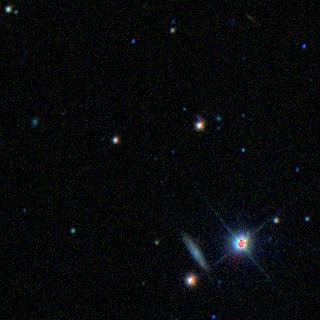

In [ ]:
image_np_with_detections = image_np.copy()
image_np_with_detections
cv2_imshow(image_np_with_detections)

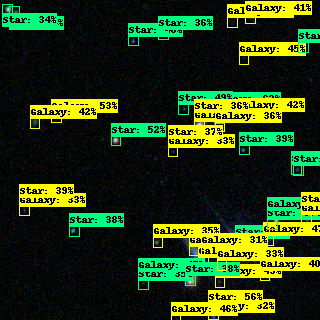

In [ ]:
viz_utils.visualize_boxes_and_labels_on_image_array(
    image_np_with_detections,
    detections['detection_boxes'],
    detections['detection_classes'],
    detections['detection_scores'],
    category_index,
    max_boxes_to_draw = 100,
    min_score_thresh=0.3,
    use_normalized_coordinates = True,
    line_thickness = 1
)

cv2_imshow(image_np_with_detections)